**Problem**: Astronomers have discovered two mysterious point sources that are both decreasing in brightness over time. You are interested in observing them in the future, and need to predict how bright they will be at the time of the observations. The data provided give the observation time (x), measured brightness (y), and estimated 1-sigma uncertainty on the brightness measurement (ysd), on the two sources obtained from the same telescope/instrument.
Predict the brightness and the uncertainty in that brightness at time x=150 for both sources. We are most interested in your approach to solving the problem, rather than the correct answer.

In [1]:
import pandas as pd
import numpy as np

from astroML.linear_model import (LinearRegression, PolynomialRegression,
                                  BasisFunctionRegression, NadarayaWatson)


from scipy.optimize import curve_fit
from astropy.stats import median_absolute_deviation as nmad

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
df = pd.DataFrame.from_csv('provided_data.csv')
df['index'] = np.arange(len(df))
df = df.set_index('index');
df['ly1'] = np.log10(df['y1'])
df['ly2'] = np.log10(df['y2'])
df['lysd1'] = 0.434*df['ysd1']/df['y1']
df['lysd2'] = 0.434*df['ysd2']/df['y2']

/Users/imomcheva/anaconda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [3]:
df

,y1,ysd1,x2,y2,ysd2,ly1,ly2,lysd1,lysd2
index,,,,,,,,,
0,59.549440,5.917314,4.270217,46.795047,5.816691,1.774878,1.670200,0.043126,0.053947
1,69.225899,5.554885,8.910880,59.439858,5.460515,1.840269,1.774078,0.034825,0.039870
2,38.799797,5.283785,13.221117,36.313026,5.167074,1.588829,1.560062,0.059102,0.061755
3,39.499247,4.850563,18.144506,19.528217,4.871961,1.596589,1.290663,0.053296,0.108276
4,32.562661,4.548691,24.489967,28.597394,4.548061,1.512720,1.456326,0.060626,0.069022
5,37.107541,4.324071,29.471527,31.159800,4.333251,1.569462,1.493595,0.050573,0.060354
6,57.045593,4.201637,30.258846,30.695769,4.302189,1.756222,1.487079,0.031966,0.060828
7,24.403807,4.084333,36.896371,34.664279,4.068649,1.387458,1.539882,0.072636,0.050940
8,24.826273,3.874164,40.856437,19.811380,3.951216,1.394912,1.296915,0.067726,0.086558


**Preview Data**

In [4]:
def plot_data():
    """
    Creates a basic plot of the data.
    Returns the axes objects.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
    axes[0].errorbar(df['x2'], df['y1'], yerr=df['ysd1'], fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    axes[0].set_ylabel('Flux')
    axes[0].text(110,65,'Source 1', fontsize=15)
    axes[0].set_xlim([0,155])
    axes[0].set_ylim([1,90])
    axes[0].plot([150.,150.],[-10,100], 'r--')

    axes[1].errorbar(df['x2'], df['y2'], yerr=df['ysd2'], fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    axes[1].text(110,65,'Source 2', fontsize=15)
    axes[1].set_xlim([0,155])
    axes[1].set_ylim([1,90])
    axes[1].plot([150.,150.],[-10,100], 'r--')
        
    plt.subplots_adjust(wspace = 0.05)    
    return(axes)

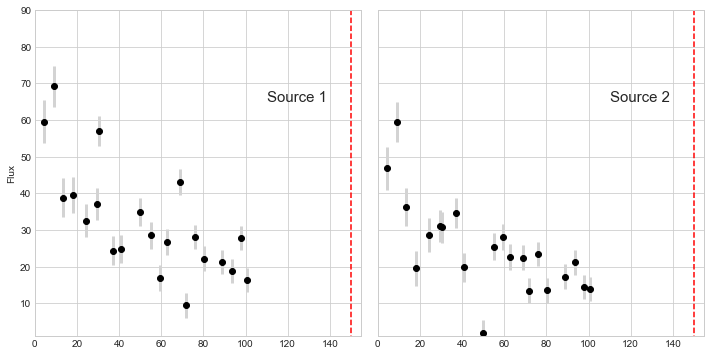

In [5]:
plot_data();

In [6]:
def log_plot_data():
    """
    Creates a basic plot of the data.
    Returns the axes objects.
    Errors: http://faculty.washington.edu/stuve/uwess/log_error.pdf
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
    axes[0].errorbar(df['x2'], df['ly1'], yerr=df['lysd1'], fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    axes[0].set_ylabel('Flux')
    axes[0].text(110,1.5,'Source 1', fontsize=15)
    axes[0].set_xlim([0,155])
    axes[0].set_ylim([0.1,2.1])
    axes[0].plot([150.,150.],[-10,100], 'r--')

    axes[1].errorbar(df['x2'], df['ly2'], yerr=df['lysd2'], fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    axes[1].text(110,1.5,'Source 2', fontsize=15)
    axes[1].set_xlim([0,155])
    axes[1].set_ylim([0.1,2.1])
    axes[1].plot([150.,150.],[-10,100], 'r--')
        
    plt.subplots_adjust(wspace = 0.05)    
    return(axes)

In [7]:
def plot_residuals(model1=None, model2=None):
        
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharey=True)

    axes[0].errorbar(df['x2'], df['y1']-model1, yerr=df['ysd1'], fmt='o', color='black',
         ecolor='lightgray', elinewidth=3, capsize=0);
    ymax = np.max(np.abs(df['y1']-model1))
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Diff')
    axes[0].set_xlim([0,155])
    axes[0].set_ylim([-1.1*ymax, 1.1*ymax])
    axes[0].plot([150.,150.],[-100,100], 'r--')
    axes[0].text(110,0.8*ymax,'Source 1', fontsize=15)

    axes[1].errorbar(df['x2'], df['y2']-model2, yerr=df['ysd1'], fmt='o', color='black',
         ecolor='lightgray', elinewidth=3, capsize=0);
    axes[1].set_xlabel('Time')
    axes[1].set_xlim([0,155])
    axes[1].set_ylim([-1.1*ymax, 1.1*ymax])
    axes[1].plot([150.,150.],[-100,100], 'r--')
    axes[1].text(110,0.8*ymax,'Source 2', fontsize=15)

    plt.subplots_adjust(wspace = 0.05)


In [8]:
def chisq(measurements,sigma,fit):
    """Calculates chi square."""
    diff=np.power(measurements-fit,2.)
    stat=(diff/np.power(sigma,2.)).sum()
    return stat

**Astropy 1D Linear Fit**

In [9]:
from astropy.modeling import models, fitting

In [10]:
fit = fitting.LinearLSQFitter()
line_init = models.Linear1D()
fitted_line1 = fit(line_init, df['x2'], df['y1'], weights=1/df['ysd1']**2)
fitted_line2 = fit(line_init, df['x2'], df['y2'], weights=1/df['ysd2']**2)

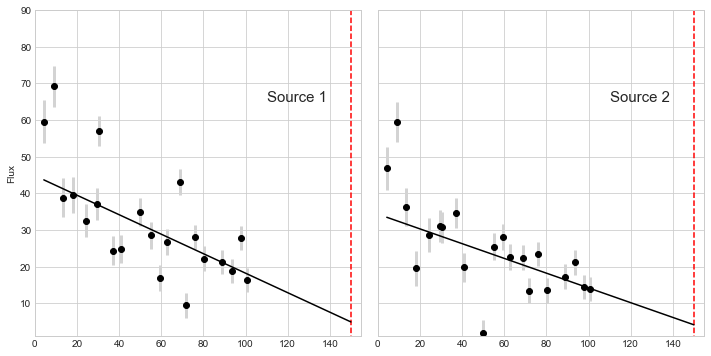

In [11]:
axes = plot_data()
axes[0].plot(np.append(df['x2'].values,150.), 
             fitted_line1(np.append(df['x2'].values,150.)), 'k-', label='Fitted Model')
axes[1].plot(np.append(df['x2'].values,150.), 
             fitted_line2(np.append(df['x2'].values,150.)), 'k-', label='Fitted Model')

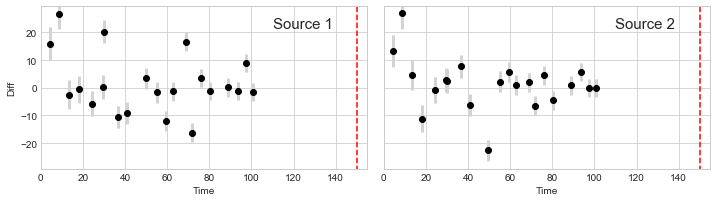

In [12]:
plot_residuals(model1=fitted_line1(df['x2']), model2=fitted_line2(df['x2']))

In [13]:
linear_chi_1 = chisq(df['y1'],df['ysd1'],fitted_line1(df['x2']))
linear_chi_2 = chisq(df['y2'],df['ysd2'],fitted_line2(df['x2']))
NDOF = len(df) - len(fitted_line1.parameters) 
print('CHI2 for Source 1:', linear_chi_1/NDOF)
print('CHI2 for Source 2:', linear_chi_2/NDOF)

CHI2 for Source 1: 7.086947585981473
CHI2 for Source 2: 4.865200258603785


Log-Linear Plot

Y1_150:  12.753704943845301
Y2_150:  8.402635717961829


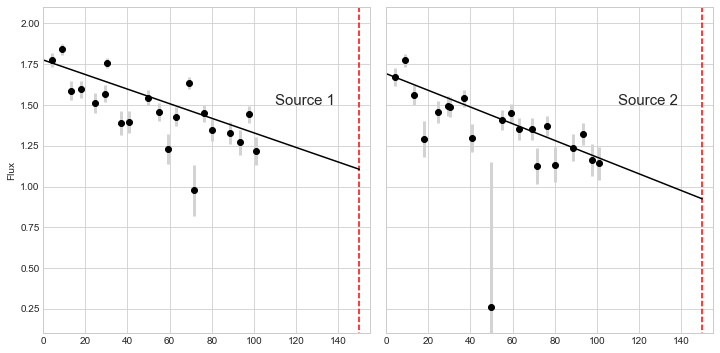

In [14]:
fit = fitting.LevMarLSQFitter()
line_init = models.Linear1D()
fitted_line1 = fit(line_init, df['x2'], df['ly1'], weights=1/df['lysd1'])
fitted_line2 = fit(line_init, df['x2'], df['ly2'], weights=1/df['lysd2'])

time = np.linspace(0,150, 50)

axes = log_plot_data()
axes[0].plot(time, fitted_line1(time), 'k-', label='Fitted Model')
axes[1].plot(time, fitted_line2(time), 'k-', label='Fitted Model')

print('Y1_150: ', 10**fitted_line1(150))
print('Y2_150: ', 10**fitted_line2(150))

In [15]:
linear_chi_1 = chisq(df['ly1'],df['lysd1'],fitted_line1(df['x2']))
linear_chi_2 = chisq(df['ly2'],df['lysd2'],fitted_line2(df['x2']))
NDOF = len(df) - len(fitted_line1.parameters) 
print('CHI2 for Source 1:', linear_chi_1/NDOF)
print('CHI2 for Source 2:', linear_chi_2/NDOF)

CHI2 for Source 1: 5.793495181024634
CHI2 for Source 2: 2.148812567337751


In [16]:
fitted_line1

<Linear1D(slope=-0.00446995, intercept=1.7761296)>

In [17]:
def func(x,a,b):
    return a*x + b

In [27]:
popt1, pcov1 = curve_fit(func, df['x2'], df['ly1'], sigma=df['lysd1'])
perr1 = np.sqrt(np.diag(pcov1))
popt2, pcov2 = curve_fit(func, df['x2'], df['ly2'], sigma=df['lysd2'])
perr2 = np.sqrt(np.diag(pcov2))

In [32]:
print(popt1, perr1)

[-0.00446995  1.7761296 ] [0.00093953 0.05046269]


<ErrorbarContainer object of 3 artists>

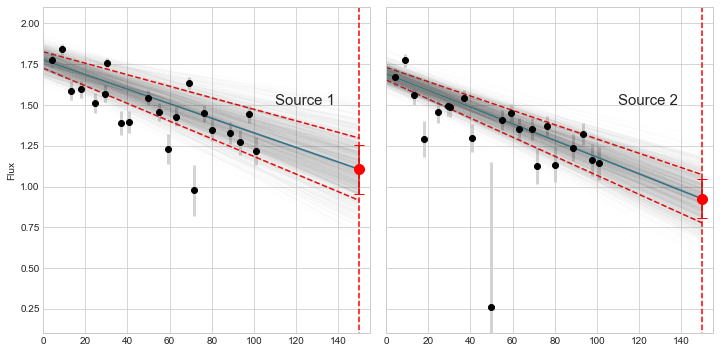

In [36]:
axes = log_plot_data()
time = np.linspace(0,150, 50)
axes[0].plot(time, func(time, *popt1));
axes[0].plot(time, func(time, popt1[0]+perr1[0], popt1[1]+perr1[1]), '--', color='red')
axes[0].plot(time, func(time, popt1[0]-perr1[0], popt1[1]-perr1[1]), '--', color='red')
axes[1].plot(time, func(time, *popt2));
axes[1].plot(time, func(time, popt2[0]+perr2[0], popt2[1]+perr2[1]), '--', color='red')
axes[1].plot(time, func(time, popt2[0]-perr2[0], popt2[1]-perr2[1]), '--', color='red')

nn = 1000

popt1_werr = np.array([np.random.normal(popt1[0],perr1[0],nn),
                            np.random.normal(popt1[1],perr1[1],nn)]).T
popt2_werr = np.array([np.random.normal(popt2[0],perr2[0],nn),
                            np.random.normal(popt2[1],perr2[1],nn)]).T

y1_150 = []
y2_150 = []

for i in range(nn):
    axes[0].plot(time, func(time, *popt1_werr[i]), 
                 color='gray', linestyle='-', alpha=0.01);
    y1_150.append(func(150., *popt1_werr[i]))
    
    axes[1].plot(time, func(time, *popt2_werr[i]), 
                 color='gray', linestyle='-', alpha=0.01);
    y2_150.append(func(150., *popt2_werr[i]))
    
axes[0].errorbar([150],func(150., *popt1), yerr = np.std(np.array(y1_150)), marker = 'o', 
                 color='red',markersize=10,capsize=5.)
axes[1].errorbar([150],func(150., *popt2), yerr = np.std(np.array(y2_150)), marker = 'o', 
                 color='red',markersize=10,capsize=5.)

In [29]:
print('Y1_150: ', 10**func(150., *popt1), ' +/- ', 10**func(150., *popt1)*np.std(np.array(y1_150))/0.434)
print('Y2_150: ', 10**func(150., *popt2), ' +/- ', 10**func(150., *popt2)*np.std(np.array(y2_150))/0.434)

Y1_150:  12.753704834884026  +/-  4.432334527550281
Y2_150:  8.402635856028715  +/-  2.134750188728486


<ErrorbarContainer object of 3 artists>

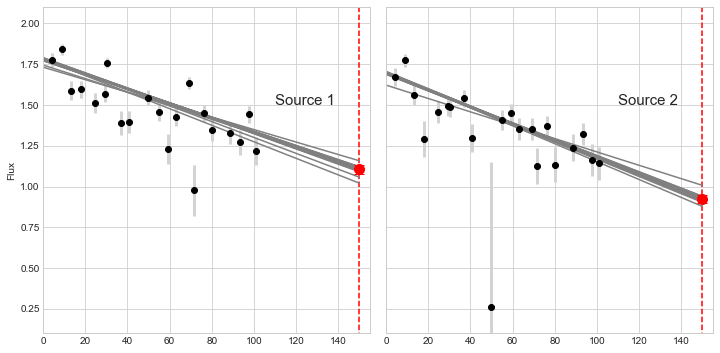

In [31]:
# Jacknife resampling - error is really small

from astropy.stats import jackknife_resampling
resamples = jackknife_resampling(np.arange(0,len(df),1, dtype='int'))

axes = log_plot_data()
time = np.linspace(0,150, 50)
axes[0].plot(time, func(time, *popt1));
axes[1].plot(time, func(time, *popt2));

y1_150 = []
y2_150 = []

for sample in resamples:
    df_tmp = df.iloc[sample,:]
    p1_sample, pcov1 = curve_fit(func, df_tmp['x2'], df_tmp['ly1'], sigma=df_tmp['lysd1'])
    p2_sample, pcov2 = curve_fit(func, df_tmp['x2'], df_tmp['ly2'], sigma=df_tmp['lysd2'])
    
    
    axes[0].plot(time, func(time, *p1_sample), 
                 color='gray', linestyle='-', alpha=1.0);
    y1_150.append(func(150., *p1_sample))
    
    axes[1].plot(time, func(time, *p2_sample), 
                 color='gray', linestyle='-', alpha=1.0);
    y2_150.append(func(150., *p2_sample))
    
axes[0].errorbar([150],func(150., *popt1), yerr = np.std(np.array(y1_150)), marker = 'o', 
                 color='red',markersize=10,capsize=5.)
axes[1].errorbar([150],func(150., *popt2), yerr = np.std(np.array(y2_150)), marker = 'o', 
                 color='red',markersize=10,capsize=5.)

**SciPy Curve Fit**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

https://swift.gsfc.nasa.gov/results/BATbursts/ASTR_288C/Lecture07_fitting.pdf

Trying an exponent fit. In principle, SciPy ```curve_fit``` can handle any user supplied function.


In [62]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [46]:
popt1, pcov1 = curve_fit(func, df['x2'], df['y1'])
perr1 = np.sqrt(np.diag(pcov1))
popt2, pcov2 = curve_fit(func, df['x2'], df['y2'])
perr2 = np.sqrt(np.diag(pcov2))

In [47]:
popt1, perr1

(array([48.48265407,  0.96211545, 20.92858097]),
 array([9.91471878, 0.01853643, 5.46501362]))

In [48]:
popt2, perr2

(array([42.36788499,  0.95193103, 17.25371297]),
 array([9.88523105, 0.02142092, 3.51388978]))

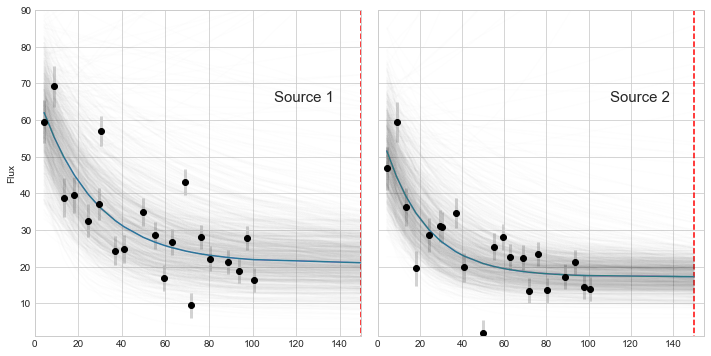

In [49]:
axes = plot_data()
axes[0].plot(np.append(df['x2'].values,150.), func(np.append(df['x2'].values,150.), *popt1));
axes[1].plot(np.append(df['x2'].values,150.), func(np.append(df['x2'].values,150.), *popt2));

nn = 1000

popt1_werr = np.array([np.random.normal(popt1[0],perr1[0],nn),
                            np.random.normal(popt1[1],perr1[1],nn),
                            np.random.normal(popt1[2],perr1[2],nn)]).T
popt2_werr = np.array([np.random.normal(popt2[0],perr2[0],nn),
                            np.random.normal(popt2[1],perr2[1],nn),
                            np.random.normal(popt2[2],perr2[2],nn)]).T

y1_150 = []
y2_150 = []

for i in range(nn):
    axes[0].plot(np.append(df['x2'].values,150.), 
                 func(np.append(df['x2'].values,150.), *popt1_werr[i]), 
                 color='gray', linestyle='-', alpha=0.01);
    y1_150.append(func(150., *popt1_werr[i]))
    
    axes[1].plot(np.append(df['x2'].values,150.), 
                 func(np.append(df['x2'].values,150.), *popt2_werr[i]), 
                 color='gray', linestyle='-', alpha=0.01);
    y2_150.append(func(150., *popt2_werr[i]))

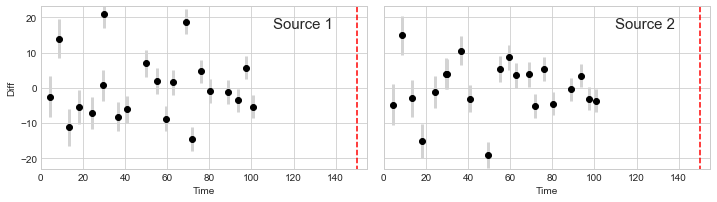

In [50]:
plot_residuals(model1=func(df['x2'], *popt1), model2=func(df['x2'], *popt2))

In [51]:
print('Y1_150: ', func(150., *popt1), ' +/- ', nmad(np.array(y1_150)))
print('Y2_150: ', func(150., *popt2), ' +/- ', nmad(np.array(y2_150)))

Y1_150:  21.076377690096848  +/-  4.560169530000302
Y2_150:  17.27988631036345  +/-  2.641757733702578


In [52]:
curve_chi_1 = chisq(df['y1'],df['ysd1'],func(df['x2'], *popt1))
curve_chi_2 = chisq(df['y2'],df['ysd2'],func(df['x2'], *popt2))
NDOF = len(df) - len(popt1) 
print('CHI2 for Source 1:', curve_chi_1/NDOF)
print('CHI2 for Source 2:', curve_chi_2/NDOF)

CHI2 for Source 1: 6.238822356880376
CHI2 for Source 2: 4.061657008619828


**```astroML``` Classifiers**

Chapter 8 of the [Statistics, Data Mining and ML book](https://www.amazon.com/Statistics-Mining-Machine-Learning-Astronomy) covers regression in a lot of detail.
I'm using [this example](https://www.astroml.org/book_figures/chapter8/fig_regression_mu_z.html) and [this one](https://www.astroml.org/book_figures/chapter8/fig_gp_example.html).

Polynomial Regression

In [237]:
# # Chi^2 not any better than exponential, but unphysical
# n1 = 4
# n2 = 3

# time = np.linspace(0,150, 50)

# fit1_pr = PolynomialRegression(n1)
# fit2_pr = PolynomialRegression(n2)

# fit1_pr.fit(df['x2'][:, None], df['y1'], df['ysd1'])
# fit2_pr.fit(df['x2'][:, None], df['y2'], df['ysd2'])

# y1_sample_fit = fit1_pr.predict(df['x2'][:, None])
# y1_fit = fit1_pr.predict(time[:, None])

# y2_sample_fit = fit2_pr.predict(df['x2'][:, None])
# y2_fit = fit2_pr.predict(time[:, None])

# axes = plot_data()
# axes[0].plot(time, y1_fit, '-k');
# axes[1].plot(time, y2_fit, '-k');

# curve_chi_1 = chisq(df['y1'],df['ysd1'],y1_sample_fit)
# curve_chi_2 = chisq(df['y2'],df['ysd2'],y2_sample_fit)
# print('CHI2 for Source 1:', curve_chi_1/(len(df) - (n1+1)))
# print('CHI2 for Source 2:', curve_chi_2/(len(df) - (n2+1)))

Basis Funcion Regression with Gaussians

CHI2 for Source 1: 8.323968700959709
CHI2 for Source 2: 3.7816255367287877


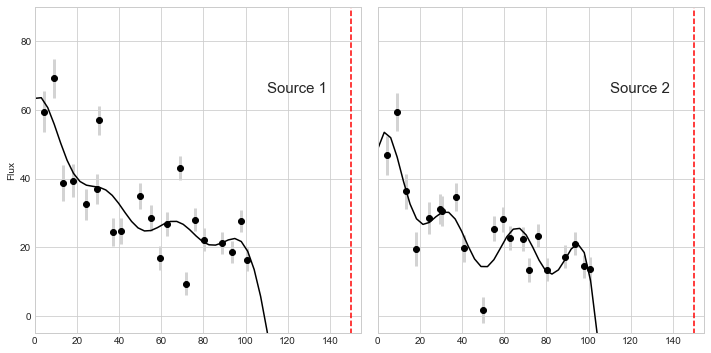

In [256]:
# Hmpf.
basis_mu = np.linspace(0, 100, 7)[:, None]
basis_sigma = 1 * (basis_mu[1] - basis_mu[0])

time = np.linspace(0,150, 50)

fit1_bfr = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
fit2_bfr = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)

fit1_bfr.fit(df['x2'][:, None], df['y1'], df['ysd1'])
fit2_bfr.fit(df['x2'][:, None], df['y2'], df['ysd2'])

y1_sample_fit = fit1_bfr.predict(df['x2'][:, None])
y1_fit = fit1_bfr.predict(time[:, None])

y2_sample_fit = fit2_bfr.predict(df['x2'][:, None])
y2_fit = fit2_bfr.predict(time[:, None])

axes = plot_data()
axes[0].plot(time, y1_fit, '-k');
axes[1].plot(time, y2_fit, '-k');

curve_chi_1 = chisq(df['y1'],df['ysd1'],y1_sample_fit)
curve_chi_2 = chisq(df['y2'],df['ysd2'],y2_sample_fit)
print('CHI2 for Source 1:', curve_chi_1/(len(df) - (len(basis_mu)+1)))
print('CHI2 for Source 2:', curve_chi_2/(len(df) - (len(basis_mu)+1)))

Gaussian Kernel Regression

CHI2 for Source 1: 1.6058975375872613
CHI2 for Source 2: 0.9619681624480372


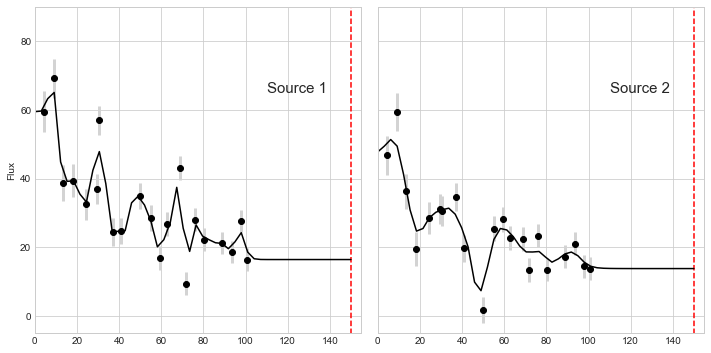

In [261]:
# Hmpf.
h1 = 2.0
h2 = 3.5

fit1_nw = NadarayaWatson('gaussian', h=h1)
fit2_nw = NadarayaWatson('gaussian', h=h2)

fit1_nw.fit(df['x2'][:, None], df['y1'], df['ysd1'])
fit2_nw.fit(df['x2'][:, None], df['y2'], df['ysd2'])

y1_sample_fit = fit1_nw.predict(df['x2'][:, None])
y1_fit = fit1_nw.predict(time[:, None])

y2_sample_fit = fit2_nw.predict(df['x2'][:, None])
y2_fit = fit2_nw.predict(time[:, None])

axes = plot_data()
axes[0].plot(time, y1_fit, '-k');
axes[1].plot(time, y2_fit, '-k');

curve_chi_1 = chisq(df['y1'],df['ysd1'],y1_sample_fit)
curve_chi_2 = chisq(df['y2'],df['ysd2'],y2_sample_fit)
print('CHI2 for Source 1:', curve_chi_1/(len(df) - 1))
print('CHI2 for Source 2:', curve_chi_2/(len(df) - 1))

SNooPy: Carnegie SN project https://users.obs.carnegiescience.edu/cburns/SNooPyDocs/html/snpy.html